# Problem Statement:

The vanilla Viterbi algorithm is a simple probability based technique to Part of Speech (POS) tagging the words of sentences. However this algorithm is too simpleton when it encounters unknown words (i.e. not present in the training set, such as 'Twitter'), as it assigns an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this assignment, we would modify the Viterbi algorithm to solve the problem of unknown words using two techniques namely,
1. Regular expression based approach 
2. Modified Viterbi algorithm

## 1. Data Preparation cum EDA

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd

from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import random

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#data check
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

From above, we note that we have list of sentences and each sentence in the form of list of words. So we have loaded the dataset into an object viz. nltk_data.

In [4]:
#checkout the total no. of sentences in the available data
len(nltk_data)

3914

In [5]:
#checkout the no. of unique POS tag tags in avalable data

print('Total no. of unique POS tags in avalable data: ', len(set([pair[1] for sent in nltk_data for pair in sent])))
print('')
print('The unique POS tags in the available data are as under: ')
print(set([pair[1] for sent in nltk_data for pair in sent]))

Total no. of unique POS tags in avalable data:  12

The unique POS tags in the available data are as under: 
{'PRON', 'ADP', 'PRT', 'NOUN', 'CONJ', 'DET', 'NUM', 'VERB', 'X', 'ADJ', '.', 'ADV'}


So we have following 12 POS tags in our entire dataset:

|POS|Description|
|---|---|
|CONJ| Conjunction (Connects words, phrases, and clauses)|
|VERB |Verb (verb of any form)|
| ADJ |Adjective (Words describing noun)|
| X| Foreign word (The tag X is used for words that for some reason cannot be assigned a real part-of-speech category)|
| ADV| Adverb (Words modifying a verb, adjective or other adverb)|
| ADP |Adposition (Adposition is a cover term for prepositions and postpositions)|
| PRON| Pronoun (Substitutes of noun)|
| NOUN |Noun (name of something)|
| DET| Determiner (Describes a reference to a noun)|
| PRT |Particle (words that must be associated with another word or phrase to impart meaning)|
| .|Punctuation (Punctuation marks are non-alphabetical characters and character groups used in many languages to delimit linguistic units in printed text)|
| NUM |Cardinal Number (A numeral is a word, functioning most typically as a determiner, adjective or pronoun, that expresses a number and a relation to the number, such as quantity, sequence, frequency or fraction)|

In [6]:
#dividing the data into train and validation sets with 95:5 ratio

random.seed(1234)
train_data, val_data = train_test_split(nltk_data, test_size=0.05)

In [7]:
len(train_data)

3718

In [8]:
len(val_data)

196

In [9]:
#trainig data POS check

print(len(set([pair[1] for sent in train_data for pair in sent])))

print(set([pair[1] for sent in train_data for pair in sent]))

12
{'PRON', 'ADP', 'PRT', 'NOUN', 'CONJ', 'X', 'DET', 'VERB', 'NUM', 'ADJ', '.', 'ADV'}


In [10]:
#validation data POS check

print(len(set([pair[1] for sent in val_data for pair in sent])))

print(set([pair[1] for sent in val_data for pair in sent]))

12
{'PRON', 'ADP', 'PRT', 'NOUN', 'CONJ', 'DET', 'NUM', 'VERB', 'X', 'ADJ', '.', 'ADV'}


From above, we note that we have all 12 unique POS tags in both training and validation sets. Hence we have been able to divide the dataset in stratified way.

In [11]:
#clubbing all the trainset and validation tuples into their respective single lists
train_data_total = [tup for sent in train_data for tup in sent]
val_data_total = [tup for sent in val_data for tup in sent]

In [12]:
#total no. of words in training and validation data
print('No. of words in training dataset:  ',len(train_data_total))
print('No. of words in validation datset:  ',len(val_data_total))

No. of words in training dataset:   95542
No. of words in validation datset:   5134


In [13]:
#check training data words
train_data_total[:5]

[('Banks', 'NOUN'),
 ('could', 'VERB'),
 ('seek', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT')]

In [14]:
#check validation data words
val_data_total[:5]

[('Friends', 'NOUN'),
 ('of', 'ADP'),
 ('Education', 'NOUN'),
 ('rates', 'VERB'),
 ('South', 'NOUN')]

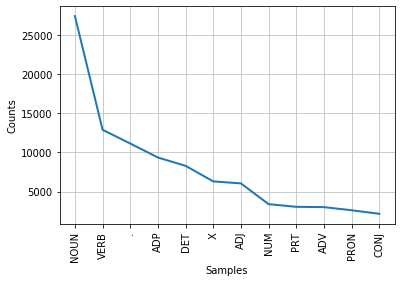

In [15]:
#check out the frequecy distribution of different POS tags in trainset
fdist1 = FreqDist([pair[1] for pair in train_data_total])

fdist1.plot()
plt.show()

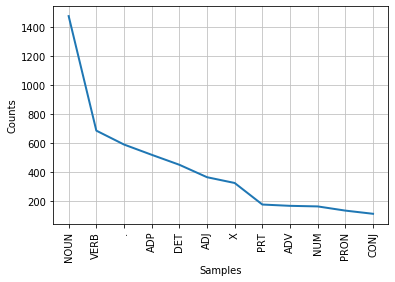

In [16]:
#check out the frequecy distribution of different POS tags in validation set
fdist2 = FreqDist([pair[1] for pair in val_data_total])

fdist2.plot()
plt.show()

From above, we note that majority of the words in both the training and validation datasets have actual tag as NOUN.

## 2. Building the vanilla Viterbi based POS tagger

Now that we have divided our dataset into training and validation sets, let's build the venilla Viterbi algorithm on the same and observe the accuracy of that model on validation dataset. For venilla Viterbi algorithm, we have to find the emission and transition probabilities of all the words and the corresponding POS tags.

In [17]:
#seperating known words and unique POS tags from training set
known_words = list(set([pair[0] for pair in train_data_total]))
TAGS = list(set([pair[1] for pair in train_data_total]))
TAGS.sort()   #sorting the tags list for uniformity

In [18]:
TAGS

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X']

In [19]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_data_total):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [20]:
# compute tag given tag: tag2 (t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_data_total):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [23]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(t_j given t_i)

tags_matrix = np.zeros((len(TAGS), len(TAGS)), dtype='float32')
for i, t1 in enumerate(TAGS):
    for j, t2 in enumerate(TAGS): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [24]:
#preparing dataframe for transition probabilities
tags_df = pd.DataFrame(tags_matrix, index = TAGS, columns=TAGS)

Let's observe the tags_df, to check for any pattern in different POS tags.

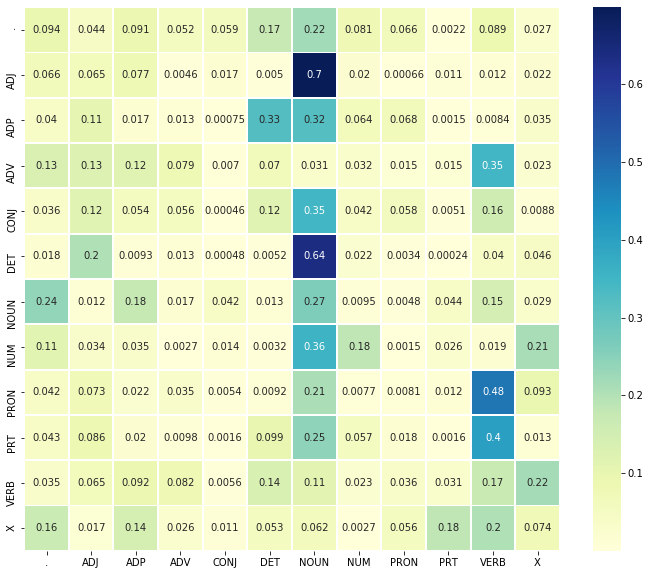

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(tags_df, annot=True, cmap="YlGnBu", linewidth=1)
plt.show()

From above we note that there is:
- high probability of NOUN occuring after ADJ
- high probability of NOUN occuring after DET
- high probability of VERB occuring after PRON

In [26]:
# vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_data_total, T=TAGS):
    state = []
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluation on vanilla Viterbi algorithm

In [27]:
val_len = len(val_data_total)   #finding length of val datset

count=0    #count the no. of matches (i.e. actual POS = predicted POS)
pred_pos = []   #to store the data in the format -------> (word, actual POS, predicted POS)
sent_count=0   #count the no. of sentences

for sent in val_data:
    words = [pair[0] for pair in sent]
    tags = [pair[1] for pair in sent]
    tot_len_sent=len(words)
    count2=0          #to count the no. of correct predictions in a given sentence
    pred_tags = [pair[1] for pair in Viterbi(words)]   #storing the predicted tags in list object 'pred_tags'
    for i,j in zip(tags,pred_tags):
        pred_pos.append((words[tags.index(i)], i, j))
        if i==j:
            count+=1
            count2+=1
    print('sent no.:',sent_count,'--->','No. of correct predictions', count2, '/', tot_len_sent)
    sent_count+=1

accuracy = count/val_len*100

print('The overall accuracy on validation set is:', accuracy,'%')

accuracy_1 = accuracy

sent no.: 0 ---> No. of correct predictions 17 / 19
sent no.: 1 ---> No. of correct predictions 27 / 28
sent no.: 2 ---> No. of correct predictions 4 / 4
sent no.: 3 ---> No. of correct predictions 26 / 33
sent no.: 4 ---> No. of correct predictions 35 / 35
sent no.: 5 ---> No. of correct predictions 18 / 23
sent no.: 6 ---> No. of correct predictions 24 / 26
sent no.: 7 ---> No. of correct predictions 7 / 8
sent no.: 8 ---> No. of correct predictions 22 / 24
sent no.: 9 ---> No. of correct predictions 18 / 19
sent no.: 10 ---> No. of correct predictions 28 / 30
sent no.: 11 ---> No. of correct predictions 29 / 33
sent no.: 12 ---> No. of correct predictions 42 / 43
sent no.: 13 ---> No. of correct predictions 23 / 26
sent no.: 14 ---> No. of correct predictions 16 / 16
sent no.: 15 ---> No. of correct predictions 25 / 29
sent no.: 16 ---> No. of correct predictions 43 / 46
sent no.: 17 ---> No. of correct predictions 32 / 35
sent no.: 18 ---> No. of correct predictions 46 / 47
sent no

## 3. Solving the problem of unknown words

From above, we note that we have got good accuracy with the help of vanilla Viterbi algorithm for POS tagging. Now let's try and improve the accuracy further. We seen that there are many words in the validation dataset, which are not present in the training dataset. Those are called unknown words. Now since they are not present in the training dataset, their emission probability will be zero and hence vanilla Viterbi algorithm would not be able to predict the POS correctly. Let's try and mitigate this issue.

Firstly, let's checkout the unknown words present in the validation dataset.

### 3.1 Model Solution I: Rule based tagging in conjunction with Viterbi algorithm

In [28]:
#create set of unknown words in validation dataset
unknown_words = list(set([pair[0] for pair in val_data_total 
                          if pair[0] not in list(set([pair[0] for pair in train_data_total]))]))

In [29]:
#total no. of unknown words in validation dataset
len(unknown_words)

350

In [30]:
unknown_words

['skip',
 'dilemma',
 'Barfield',
 'worms',
 'astonishment',
 'kindness',
 '778',
 'FreudToy',
 'unpopularity',
 'Takashima',
 'Ilminster',
 'rooted',
 'gubernatorial',
 'bothered',
 'advertorial',
 'reckless',
 'biscuit',
 'Fears',
 '9.75',
 'four-year-old',
 'Lazzaroni',
 '*T*-161',
 'DIALING',
 '6\\/2',
 'troublesome',
 'PHOTOGRAPH',
 'accordance',
 'Worksheets',
 'leeway',
 'Borough',
 'aftereffects',
 'bundles',
 'multinational',
 'sickness',
 'borrowed',
 '*T*-258',
 'juggernaut',
 'durable',
 'mid-1970s',
 'abortions',
 'Perhaps',
 'propagandizes',
 'higher-salaried',
 'Orchestra',
 'Ichiro',
 'Freud',
 '*T*-179',
 'instrument',
 'Assurance',
 '24.95',
 'Tourism',
 'cardiovascular',
 'Lt.',
 'cease-fire',
 'windfall',
 'revenue-desperate',
 '700',
 'Gayle',
 '23.72',
 'FIRST',
 'Borge',
 'crowd',
 'packed',
 'Midland',
 'Carlton',
 'refuge',
 'HUD',
 'Seattle',
 'peaked',
 'miscarriages',
 'O.',
 'trafficking',
 'ASSOCIATION',
 'disapproval',
 'Grandsire',
 'digs',
 'dust-up',
 

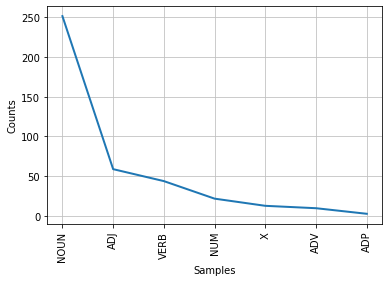

In [31]:
#checkout the actual tags of unknown words from validation set
FreqDist([pair[1] for pair in pred_pos if pair[0] in unknown_words]).plot()
plt.show()

From above, we note that most unknowns have actual POS as NOUN. Let's check each POS one by one and figure out the corresponding regex based on morphological cues of unknown words.

#### NOUN:

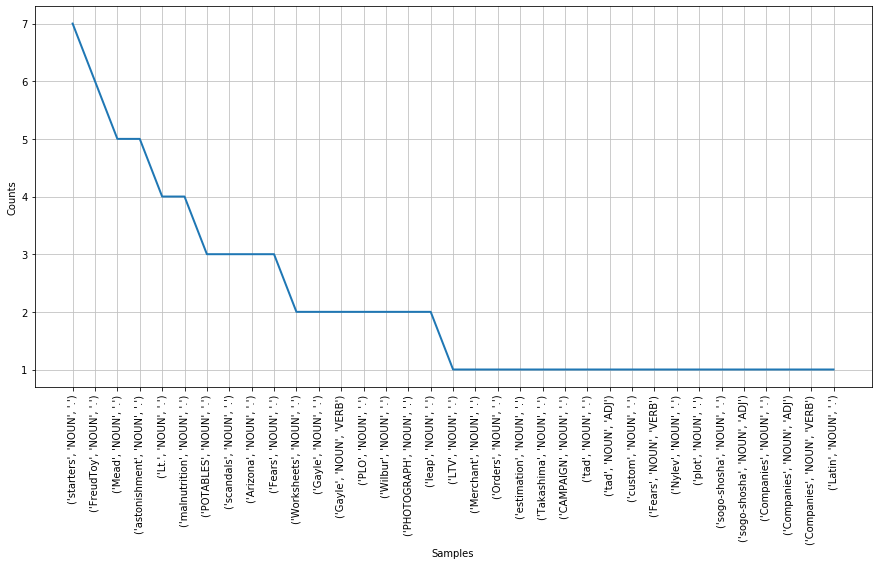

In [32]:
#checkout wrongly tagged unknown words which are actually NOUN
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='NOUN' and pair[1]!=pair[2]]).plot()
plt.show()

From above, we note that:
- Majority of unknown NOUN words have been predicted as . while some of them have been predicted as VERB and ADJ.
- We do not see any specific regular expression pattern to mitigate the issue as NOUN can be of any morphological form, in test sentences. However, NOUN is occurring highest in number, hence we can use following regular expression pattern as a backup for unknown words:

In [33]:
pattern_noun = [
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN')                    # nouns i.e. overall backup
               ]

#### ADJ

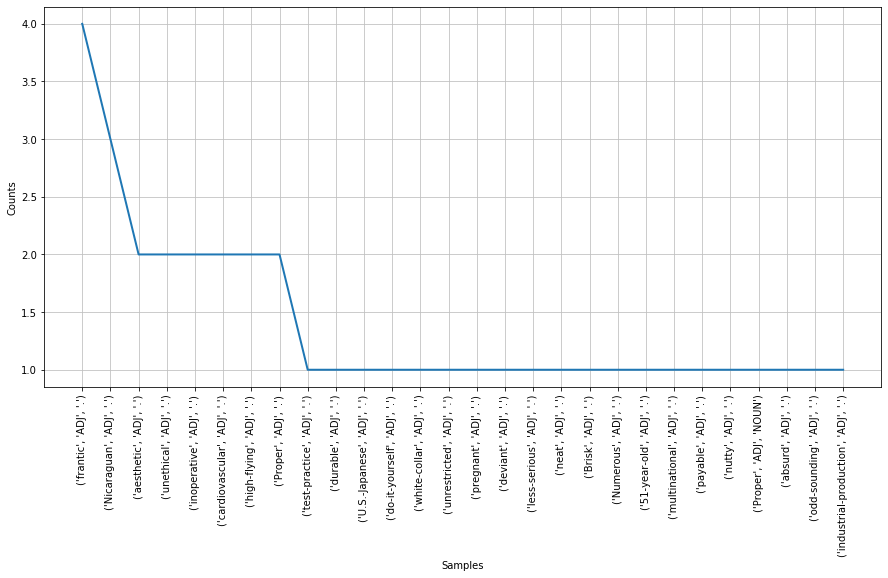

In [34]:
#checkout wrongly tagged unknown words which are actually ADJ
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='ADJ' and pair[1]!=pair[2]]).plot()
plt.show()

From above, we note that:
- very few unknown ADJ have been wrongly marked
- the wrongly marked unknown ADJ have been predicted as . or NOUN
- here as well we do not find any specific pattern to categorize the unknown word as ADJ

#### NUM

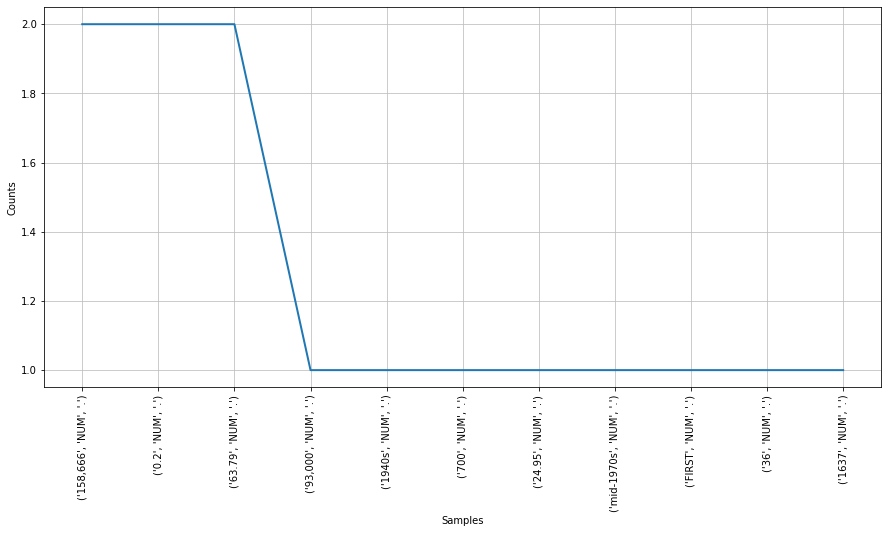

In [35]:
#checkout wrongly tagged unknown words which are actually NUM
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='NUM' and pair[1]!=pair[2]]).plot()
plt.show()

From the above, we note that:
- all the unknown NUM words have been predicted as . by our model
- we can use following regular expression and the same in conjunction with our Viterbi algorithm, to mitigate the issue:

In [36]:
pattern_num = [(r'^-?[0-9]+(.*[0-9]+)?([0-9]+)?([a-Z]+)?', 'NUM')]

#### VERB

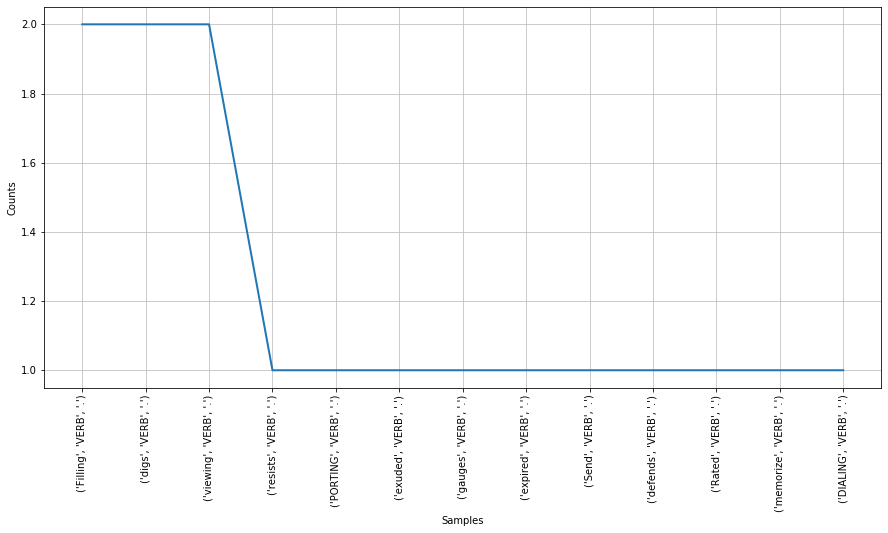

In [37]:
#checkout wrongly tagged unknown words which are actually VERB
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='VERB' and pair[1]!=pair[2]]).plot()
plt.show()

From the above, we note that:
- all the unknown VERB words have been predicted as . by our model
- we can use following regular expression and the same in conjunction with our Viterbi algorithm, to mitigate the issue:

In [38]:
pattern_verb = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
]

#### ADV

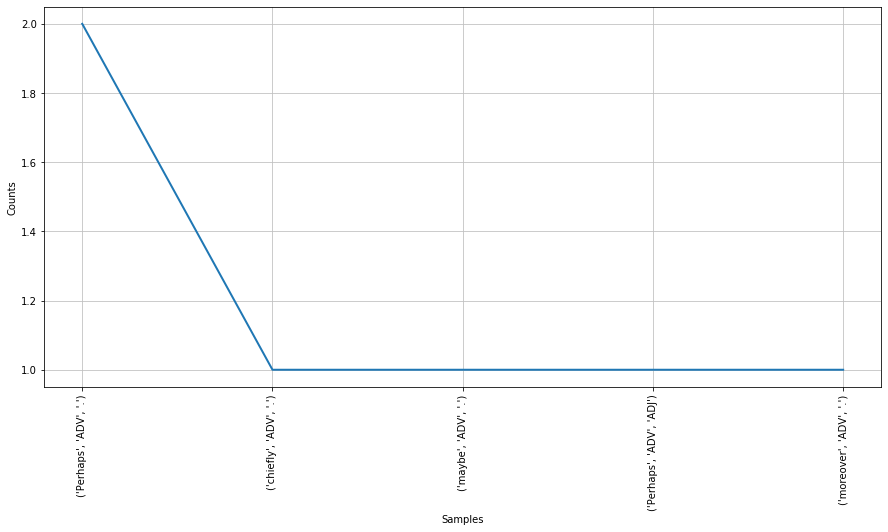

In [39]:
#checkout wrongly tagged unknown words which are actually ADV
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='ADV' and pair[1]!=pair[2]]).plot()
plt.show()

From above, we note that:
- very few unknown ADV have been wrongly marked
- the wrongly marked unknown ADJ have been predicted as . or ADJ
- here as well we do not find any specific pattern to categorize the unknown word as ADV

#### X

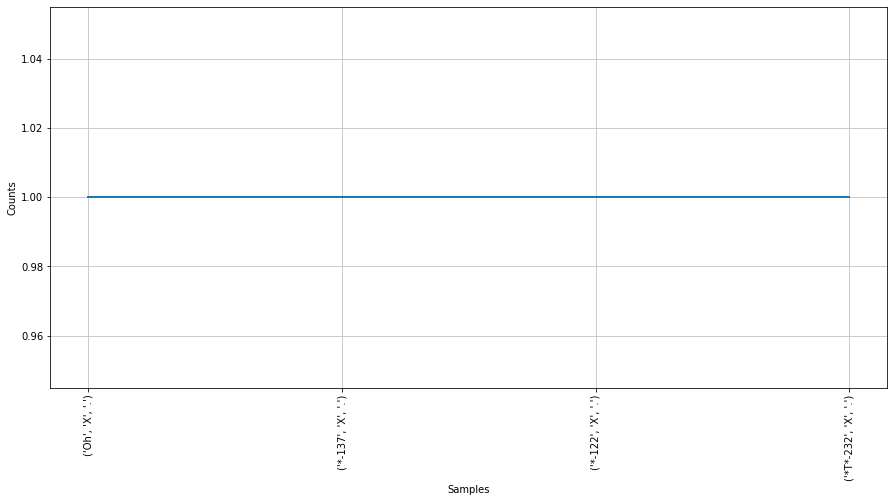

In [40]:
#checkout wrongly tagged unknown words which are actually X
plt.figure(figsize=(15,7))
FreqDist([pair for pair in pred_pos if pair[0] in unknown_words and pair[1]=='X' and pair[1]!=pair[2]]).plot()
plt.show()

From above, we note that:
- the wrongly marked unknown X have been predicted as .
- here as well we do not find any specific pattern to categorize the unknown word as X since foreign words are hard to framed with regexp

We know that **RegexpTagger** tag the words based on the priority sequence. Hence from our above analysis, let's use following regex pattern for POS tagging of unknown words:

In [41]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN')                    # nouns
]

Here we use **RegexpTagger** in conjunction with Viterbi algorithms such that our model use **RegexpTagger** for POS tagging only for unknown words.

In [42]:
def Viterbi1(words, train_bag = train_data_total, T=TAGS, patterns=patterns, known_words=known_words):
    state = []    
    regexp_tagger = nltk.RegexpTagger(patterns)   #regexptagger for unknown words
    
    for key, word in enumerate(words):
        if  word in known_words:     #if only word is known
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability =  transition_p*emission_p    
                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:    #if word if unknown
            regexp_pred = regexp_tagger.tag([word])[0][1]
            state.append(regexp_pred)
                         
    return list(zip(words, state))

In [43]:
val_len = len([pair for sent in val_data for pair in sent])   #finding length of val datset

count=0
pred_pos1 = []
sent_count=0
for sent in val_data:
    words = [pair[0] for pair in sent]
    tags = [pair[1] for pair in sent]
    tot_len_sent=len(words)
    count2=0
    pred_tags = [pair[1] for pair in Viterbi1(words)]   #storing the predicted tags in object 'pred_tags'
    for i,j in zip(tags,pred_tags):
        pred_pos1.append((words[tags.index(i)], i, j))
        if i==j:
            count+=1
            count2+=1
    print('sent no.:',sent_count,'--->','No. of correct predictions', count2, '/', tot_len_sent)
    sent_count+=1

accuracy = count/val_len*100

print('The overall accuracy on validation set is:', accuracy,'%')

accuracy_2 = accuracy

sent no.: 0 ---> No. of correct predictions 17 / 19
sent no.: 1 ---> No. of correct predictions 27 / 28
sent no.: 2 ---> No. of correct predictions 4 / 4
sent no.: 3 ---> No. of correct predictions 29 / 33
sent no.: 4 ---> No. of correct predictions 35 / 35
sent no.: 5 ---> No. of correct predictions 22 / 23
sent no.: 6 ---> No. of correct predictions 24 / 26
sent no.: 7 ---> No. of correct predictions 7 / 8
sent no.: 8 ---> No. of correct predictions 24 / 24
sent no.: 9 ---> No. of correct predictions 18 / 19
sent no.: 10 ---> No. of correct predictions 29 / 30
sent no.: 11 ---> No. of correct predictions 31 / 33
sent no.: 12 ---> No. of correct predictions 43 / 43
sent no.: 13 ---> No. of correct predictions 26 / 26
sent no.: 14 ---> No. of correct predictions 16 / 16
sent no.: 15 ---> No. of correct predictions 26 / 29
sent no.: 16 ---> No. of correct predictions 43 / 46
sent no.: 17 ---> No. of correct predictions 33 / 35
sent no.: 18 ---> No. of correct predictions 46 / 47
sent no

From above, we note that using regexptagger in tandem with Viterbi algorithm gives us improved accuracy.

### 3.2. Model Solution II: Using only Transition Probability for Viterbi Algorithm

Now let's try something different. We know that Viterbi algorithm is unable to tag unknown words properly as the corresponding emission probabilities are zero. Let's try and use only transition probabilities for unknown words and analyse the model.

In [44]:
def Viterbi2(words, train_bag = train_data_total, T=TAGS, known_words=known_words):
    state = []
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in known_words:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p=1   #only consider transition probability when word not in train data (known_words)
                
            state_probability =  transition_p*emission_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [45]:
val_len = len([pair for sent in val_data for pair in sent])   #finding length of val datset

count=0
pred_pos2 = []
sent_count=0
for sent in val_data:
    words = [pair[0] for pair in sent]
    tags = [pair[1] for pair in sent]
    tot_len_sent=len(words)
    count2=0
    pred_tags = [pair[1] for pair in Viterbi2(words)]   #storing the predicted tags in object 'pred_tags'
    for i,j in zip(tags,pred_tags):
        pred_pos2.append((words[tags.index(i)], i, j))
        if i==j:
            count+=1
            count2+=1
    print('sent no.:',sent_count,'--->','No. of correct predictions', count2, '/', tot_len_sent)
    sent_count+=1

accuracy = count/val_len*100

print('The overall accuracy on validation set is:', accuracy,'%')

accuracy_3 = accuracy

sent no.: 0 ---> No. of correct predictions 17 / 19
sent no.: 1 ---> No. of correct predictions 27 / 28
sent no.: 2 ---> No. of correct predictions 4 / 4
sent no.: 3 ---> No. of correct predictions 31 / 33
sent no.: 4 ---> No. of correct predictions 35 / 35
sent no.: 5 ---> No. of correct predictions 21 / 23
sent no.: 6 ---> No. of correct predictions 24 / 26
sent no.: 7 ---> No. of correct predictions 7 / 8
sent no.: 8 ---> No. of correct predictions 22 / 24
sent no.: 9 ---> No. of correct predictions 18 / 19
sent no.: 10 ---> No. of correct predictions 29 / 30
sent no.: 11 ---> No. of correct predictions 31 / 33
sent no.: 12 ---> No. of correct predictions 43 / 43
sent no.: 13 ---> No. of correct predictions 23 / 26
sent no.: 14 ---> No. of correct predictions 16 / 16
sent no.: 15 ---> No. of correct predictions 26 / 29
sent no.: 16 ---> No. of correct predictions 44 / 46
sent no.: 17 ---> No. of correct predictions 32 / 35
sent no.: 18 ---> No. of correct predictions 46 / 47
sent no

## 4. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
pd.DataFrame({'Algorithm':['Vanilla Veterbi','RegexpTagger in tandem with Viterbi','Viterbi with only Transition probability'],
             'POS tagging Accuracy (in %)':[accuracy_1,accuracy_2,accuracy_3]}).set_index(['Algorithm'])

,POS tagging Accuracy (in %)
Algorithm,
Vanilla Veterbi,90.241527
RegexpTagger in tandem with Viterbi,94.740943
Viterbi with only Transition probability,93.572263


From above, we can note that we have been able to improve the POS tagging accuracy by tweaking the original Viterbi algorithm

## 5. List down cases which were incorrectly tagged by original POS tagger and got corrected by modifications

Let's first load the sample test case dataset.

In [47]:
from urllib.request import urlopen
page = urlopen("https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt")
test_data = page.read().decode('utf-8')

In [48]:
test_data

"Android is a mobile operating system developed by Google.\r\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\r\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\nShow me the cheapest round trips from Dallas to Atlanta\r\nI would like to see flights from Denver to Philadelphia.\r\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\nNASA invited social media users to experience the launc

Now since we do not know the actual POS tags of the test set, let's use following online tool for processing the same:
http://textanalysisonline.com/spacy-pos-tagging

The POS tags we obtained for the testset are as under:

**Android|NOUN is|VERB a|DET mobile|ADJ operating|VERB system|NOUN developed|VERB by|ADP Google|NOUN .|PUNCT |ADJ Android|NOUN has|VERB been|VERB the|DET best|ADV -|PUNCT selling|VERB OS|NOUN worldwide|ADV on|ADP smartphones|NOUN since|ADP 2011|NUM and|CONJ on|ADP tablets|NOUN since|ADP 2013|NUM .|PUNCT |PUNCT Google|NOUN and|CONJ Twitter|NOUN made|VERB a|DET deal|NOUN in|ADP 2015|NUM that|ADJ gave|VERB Google|NOUN access|NOUN to|ADP Twitter|NOUN 's|PART firehose|NOUN .|PUNCT |PUNCT Twitter|NOUN is|VERB an|DET online|ADJ news|NOUN and|CONJ social|ADJ networking|NOUN service|NOUN on|ADP which|ADJ users|NOUN post|VERB and|CONJ interact|VERB with|ADP messages|NOUN known|VERB as|ADP tweets|NOUN .|PUNCT |X Before|ADP entering|VERB politics|NOUN ,|PUNCT Donald|NOUN Trump|NOUN was|VERB a|DET domineering|ADJ businessman|NOUN and|CONJ a|DET television|NOUN personality|NOUN .|PUNCT |NUM The|DET 2018|NUM FIFA|NOUN World|NOUN Cup|NOUN is|VERB the|DET 21st|ADJ FIFA|NOUN World|NOUN Cup|NOUN ,|PUNCT an|DET international|ADJ football|NOUN tournament|NOUN contested|VERB once|ADV every|DET four|NUM years|NOUN .|PUNCT |PUNCT This|DET is|VERB the|DET first|ADJ World|NOUN Cup|NOUN to|PART be|VERB held|VERB in|ADP Eastern|NOUN Europe|NOUN and|CONJ the|DET 11th|ADJ time|NOUN that|ADJ it|NOUN has|VERB been|VERB held|VERB in|ADP Europe|NOUN .|PUNCT |NOUN Show|NOUN me|NOUN the|DET cheapest|ADJ round|NOUN trips|NOUN from|ADP Dallas|NOUN to|ADP Atlanta|NOUN |NOUN I|NOUN would|VERB like|VERB to|PART see|VERB flights|NOUN from|ADP Denver|NOUN to|ADP Philadelphia|NOUN .|PUNCT |NOUN Show|NOUN me|NOUN the|DET price|NOUN of|ADP the|DET flights|NOUN leaving|VERB Atlanta|NOUN at|ADP about|ADP 3|NUM in|ADP the|DET afternoon|NOUN and|CONJ arriving|VERB in|ADP San|NOUN Francisco|NOUN .|PUNCT |NOUN NASA|NOUN invited|VERB social|ADJ media|NOUN users|NOUN to|PART experience|VERB the|DET launch|NOUN of|ADP ICESAT-2|NOUN Satellite|NOUN .|PUNCT**

We would use above tags for reference. Now, let's process the test dataset.

In [49]:
#tokanizing the words from test dataset
test_data_total = nltk.word_tokenize(test_data)

In [50]:
test_data_total

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

Let's build a dataframe containing following columns:
- all the words from test dataset
- POS tags predicted by Vanilla Veterbi algorithm
- POS tags predicted by RegexpTagger in tandem with Veterbi algorithm (Model Solution I)
- POS tags predicted by Viterbi with only Transition probability (Model Solution II)

We would use the above dataframe for comparison of various cases.

In [51]:
words = test_data_total
pred_vanilla = [pair[1] for pair in Viterbi(test_data_total)]
pred_MS_I = [pair[1] for pair in Viterbi1(test_data_total)]
pred_MS_II = [pair[1] for pair in Viterbi2(test_data_total)]

In [52]:
total_predict_df = pd.DataFrame({'words':words,
                                'pred_vanilla':pred_vanilla,
                                'pred_MS_I':pred_MS_I,
                                'pred_MS_II':pred_MS_II})

In [53]:
total_predict_df.head(10)

,words,pred_vanilla,pred_MS_I,pred_MS_II
0,Android,.,NOUN,NOUN
1,is,VERB,VERB,VERB
2,a,DET,DET,DET
3,mobile,ADJ,ADJ,ADJ
4,operating,NOUN,NOUN,NOUN
5,system,NOUN,NOUN,NOUN
6,developed,VERB,VERB,VERB
7,by,ADP,ADP,ADP
8,Google,.,NOUN,DET
9,.,.,.,.


### 5.1 Vanilla Veterbi	vs RegexpTagger in tandem with Viterbi (MS-I)

In [54]:
comp_df1 = total_predict_df[(total_predict_df.pred_vanilla!=total_predict_df.pred_MS_I)].drop(['pred_MS_II'], axis=1)

comp_df1

,words,pred_vanilla,pred_MS_I
0,Android,.,NOUN
8,Google,.,NOUN
10,Android,.,NOUN
15,OS,.,NOUN
16,worldwide,.,NOUN
18,smartphones,.,VERB
20,2011,.,NUM
25,2013,.,NUM
27,Google,.,NOUN
29,Twitter,.,NOUN


In [55]:
print('From above, we note that we have %d words where our model solution-I has predicted differenly compared to vanilla Viterbi'%(comp_df1.shape[0]))

From above, we note that we have 38 words where our model solution-I has predicted differenly compared to vanilla Viterbi


Following is list of three cases from the sample test file which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications no. I:
1. Google
2. Android
3. OS

All the above three are NOUN but have been tagged as . by original model and corrected by model solution I. Further, there are some wrongly tagged VERB like invited, arriving, contested, which have been corrected by model solution I.

### 5.2 Vanilla Veterbi	vs Viterbi with only Transition probability (MS-II)

In [56]:
comp_df2 = total_predict_df[(total_predict_df.pred_vanilla!=total_predict_df.pred_MS_II)].drop(['pred_MS_I'], axis=1)

comp_df2

,words,pred_vanilla,pred_MS_II
0,Android,.,NOUN
8,Google,.,DET
10,Android,.,NOUN
15,OS,.,NOUN
16,worldwide,.,NOUN
18,smartphones,.,DET
20,2011,.,DET
25,2013,.,DET
27,Google,.,NOUN
29,Twitter,.,NOUN


In [57]:
print('From above, we note that we have %d words where our model solution-II has predicted differenly compared to vanilla Viterbi'%(comp_df2.shape[0]))

From above, we note that we have 38 words where our model solution-II has predicted differenly compared to vanilla Viterbi


Following is list of three cases from the sample test file which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications no. II:
1. Cup
2. FIFA
3. Tournament

All the above three are NOUN but have been tagged as . by original model and corrected by model solution II.

---------------------------------------------------------------------------------------------------------------------------